# Data preparation

In [ ]:
from google.colab import drive
import pickle
from sklearn.model_selection import StratifiedKFold
import numpy as np
import cv2

drive.mount('/content/drive')
with open('/content/drive/My Drive/CNT_IMG_color.pkl', 'rb') as file:
    CNT_IMG = pickle.load(file)  # list of (image, content, method, name)

# CNT_IMG = list of (img_array, content, method, name)
contents = np.array([s[1] for s in CNT_IMG])

Mounted at /content/drive


In [ ]:
target_crop = (1080,1920)
crop_h, crop_w = target_crop

def crop_image(img_array, content, method, name, crop_h, crop_w):
    H, W = img_array.shape[:2]
    crops = []
    for i in range(H // crop_h):
        for j in range(W // crop_w):
            sub_img = img_array[i*crop_h:(i+1)*crop_h, j*crop_w:(j+1)*crop_w]
            crops.append([sub_img, content, method, name])
    return crops

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_fold_sets = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(CNT_IMG, contents)):
    print(f"\n Fold {fold+1}/5")

    train_imgs = [CNT_IMG[i] for i in train_idx]
    test_imgs = [CNT_IMG[i] for i in test_idx]

    SMALL_TRAIN = []
    SMALL_TEST = []

    for img_array, content, method, name in train_imgs:
        SMALL_TRAIN.extend(crop_image(img_array, content, method, name, crop_h, crop_w))
    for img_array, content, method, name in test_imgs:
        SMALL_TEST.extend(crop_image(img_array, content, method, name, crop_h, crop_w))

    outer_fold_sets.append((SMALL_TRAIN, SMALL_TEST))

print(f"\n Total outer folds: {len(outer_fold_sets)}")

In [ ]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

def random_color_adjust(img):
    # img: tf.Tensor of shape (H, W, 3), dtype=tf.float32, range [0, 1]
    # Brightness
    brightness_delta = random.uniform(-0.1, 0.1)
    img = tf.image.adjust_brightness(img, delta=brightness_delta)
    # Contrast
    contrast_factor = random.uniform(0.8, 1.2)
    img = tf.image.adjust_contrast(img, contrast_factor)
    # Gamma
    gamma = random.uniform(0.7, 1.3)
    img = tf.image.adjust_gamma(img, gamma=gamma)
    # Hue
    hue_delta = random.uniform(-0.05, 0.05)
    img = tf.image.adjust_hue(img, delta=hue_delta)
    # Saturation
    saturation_factor = random.uniform(0.8, 1.2)
    img = tf.image.adjust_saturation(img, saturation_factor)
    return img

In [ ]:
def prepare_rgb_fold_dataset(train_imgs, test_imgs, bins=128):
    def extract_rgb_histogram(img):
        hist_r = np.histogram(img[:, :, 0], bins=bins, range=(0, 255))[0]
        hist_g = np.histogram(img[:, :, 1], bins=bins, range=(0, 255))[0]
        hist_b = np.histogram(img[:, :, 2], bins=bins, range=(0, 255))[0]
        hist = np.concatenate([hist_r, hist_g, hist_b])
        return hist

    X_train, y_content_train, y_disp_train = [], [], []
    for img, content, method, name in train_imgs:
        X_train.append(extract_rgb_histogram(img))
        y_content_train.append(content)
        y_disp_train.append(method)
        for _ in range(4):
            aug_img = random_color_adjust(tf.convert_to_tensor(img / 255.0, dtype=tf.float32)).numpy() * 255.0
            X_train.append(extract_rgb_histogram(aug_img))
            y_content_train.append(content)
            y_disp_train.append(method)

    X_test, y_content_test, y_disp_test = [], [], []
    for img, content, method, name in test_imgs:
        X_test.append(extract_rgb_histogram(img))
        y_content_test.append(content)
        y_disp_test.append(method)

    return np.array(X_train), np.array(y_content_train), np.array(y_disp_train), \
           np.array(X_test), np.array(y_content_test), np.array(y_disp_test)


In [ ]:
def prepare_rgb_fold_test_dataset(train_imgs, test_imgs, bins=128):
    def extract_rgb_histogram(img):
        hist_r = np.histogram(img[:, :, 0], bins=bins, range=(0, 255))[0]
        hist_g = np.histogram(img[:, :, 1], bins=bins, range=(0, 255))[0]
        hist_b = np.histogram(img[:, :, 2], bins=bins, range=(0, 255))[0]
        hist = np.concatenate([hist_r, hist_g, hist_b])
        return hist

    X_test, y_content_test, y_disp_test = [], [], []
    for img, content, method, name in test_imgs:
        X_test.append(extract_rgb_histogram(img))
        y_content_test.append(content)
        y_disp_test.append(method)

    return np.array(X_test), np.array(y_content_test), np.array(y_disp_test)


# ML models

## SVC

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory
base_dir = "/content/drive/My Drive/Results/SVC"
os.makedirs(base_dir, exist_ok=True)

# Initialize list
content_accs, method_accs = [], []
content_f1s, method_f1s = [], []

for fold_idx, (train_imgs, test_imgs) in enumerate(outer_fold_sets):
    print(f"\n Fold {fold_idx + 1}")

    # Data preparation
    X_train, y_content_train, y_disp_train, X_test, y_content_test, y_disp_test = prepare_rgb_fold_dataset(train_imgs, test_imgs, bins=64)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC())
    ])
    param_grid = {
        'svm__C': [0.01, 0.1, 1],
        'svm__kernel': ['linear', 'rbf'],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1]
    }

    # Content classifier
    grid_content = GridSearchCV(pipe, param_grid, cv=5)
    grid_content.fit(X_train, np.array(y_content_train))
    best_content = grid_content.best_estimator_
    y_pred_content = best_content.predict(X_test)

    # Method classifier
    grid_method = GridSearchCV(pipe, param_grid, cv=5)
    grid_method.fit(X_train, np.array(y_disp_train))
    best_method = grid_method.best_estimator_
    y_pred_method = best_method.predict(X_test)

    # Save
    joblib.dump(best_content, f"{base_dir}/fold{fold_idx+1}_content_model.joblib")
    joblib.dump(best_method, f"{base_dir}/fold{fold_idx+1}_method_model.joblib")

    # Evaluation
    acc_content = accuracy_score(y_content_test, y_pred_content)
    acc_method = accuracy_score(y_disp_test, y_pred_method)
    f1_content = f1_score(y_content_test, y_pred_content, average='macro')
    f1_method = f1_score(y_disp_test, y_pred_method, average='macro')

    content_accs.append(acc_content)
    method_accs.append(acc_method)
    content_f1s.append(f1_content)
    method_f1s.append(f1_method)

    print(f" Fold {fold_idx+1} CONTENT acc: {acc_content:.3f}, F1: {f1_content:.3f}")
    print(f" Fold {fold_idx+1} METHOD acc: {acc_method:.3f}, F1: {f1_method:.3f}")

    # Confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(confusion_matrix(y_content_test, y_pred_content), annot=True, fmt='d', ax=axes[0])
    axes[0].set_title(f'Fold {fold_idx+1} - CONTENT')
    sns.heatmap(confusion_matrix(y_disp_test, y_pred_method), annot=True, fmt='d', ax=axes[1])
    axes[1].set_title(f'Fold {fold_idx+1} - METHOD')
    plt.tight_layout()
    plt.savefig(f"{base_dir}/fold{fold_idx+1}_confusion_matrices.png")
    plt.close()

# Average performance
print("\n Overall Performance:")
print(f"CONTENT_Accuracy: {np.mean(content_accs):.3f}, Macro F1: {np.mean(content_f1s):.3f}")
print(f"METHOD_Accuracy: {np.mean(method_accs):.3f}, Macro F1: {np.mean(method_f1s):.3f}")


In [ ]:
import joblib

base_dir = "/content/drive/My Drive/Results/SVC"

print("Best hyperparameters:")

for fold_idx in range(5):
    # Load model
    content_model = joblib.load(f"{base_dir}/fold{fold_idx+1}_content_model.joblib")
    method_model = joblib.load(f"{base_dir}/fold{fold_idx+1}_method_model.joblib")

    # Extract parameters
    content_params = content_model.named_steps['svm'].get_params()
    method_params = method_model.named_steps['svm'].get_params()

    print(f"\n Fold {fold_idx+1}")
    print(f"CONTENT Params: C={content_params['C']}, kernel='{content_params['kernel']}', gamma={content_params['gamma']}")
    print(f"METHOD  Params: C={method_params['C']}, kernel='{method_params['kernel']}', gamma={method_params['gamma']}")


In [ ]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier

# Directory
base_dir = "/content/drive/My Drive/Results/SVC"
os.makedirs(base_dir, exist_ok=True)

# Initialization
cm_content_total = None
cm_method_total = None

method_specific_cm = {
    0: {"true": [], "pred": []},  # shear
    1: {"true": [], "pred": []}   # sonic
}

for fold_idx in range(5):
    # Load model
    content_model = joblib.load(f"{base_dir}/fold{fold_idx+1}_content_model.joblib")
    method_model = joblib.load(f"{base_dir}/fold{fold_idx+1}_method_model.joblib")

    # Test dataset
    train_imgs, test_imgs = outer_fold_sets[fold_idx]
    X_test, y_content_test, y_disp_test = prepare_rgb_fold_test_dataset(train_imgs, test_imgs, bins=64)

    # Prediction
    y_pred_content = content_model.predict(X_test)
    y_pred_method = method_model.predict(X_test)

    # Confusion matrix
    cm_c = confusion_matrix(y_content_test, y_pred_content)
    cm_m = confusion_matrix(y_disp_test, y_pred_method)

    cm_content_total = cm_c if cm_content_total is None else cm_content_total + cm_c
    cm_method_total = cm_m if cm_method_total is None else cm_method_total + cm_m

    for method_code in method_specific_cm.keys():
        mask = np.array(y_disp_test) == method_code
        method_specific_cm[method_code]["true"].extend(np.array(y_content_test)[mask])
        method_specific_cm[method_code]["pred"].extend(np.array(y_pred_content)[mask])

# Normalization
cm_content_norm = cm_content_total.astype('float') / cm_content_total.sum(axis=1)[:, np.newaxis]
cm_method_norm = cm_method_total.astype('float') / cm_method_total.sum(axis=1)[:, np.newaxis]



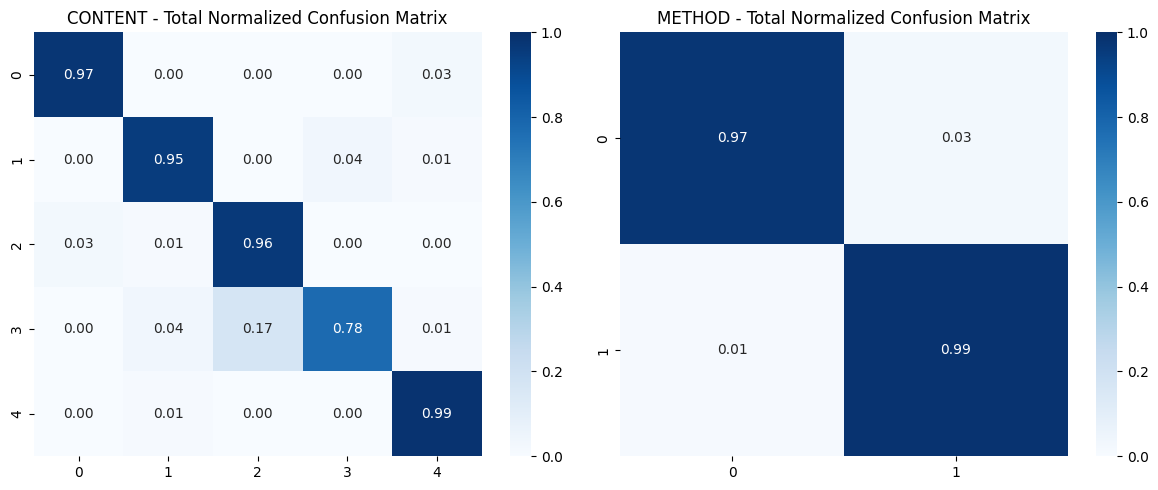

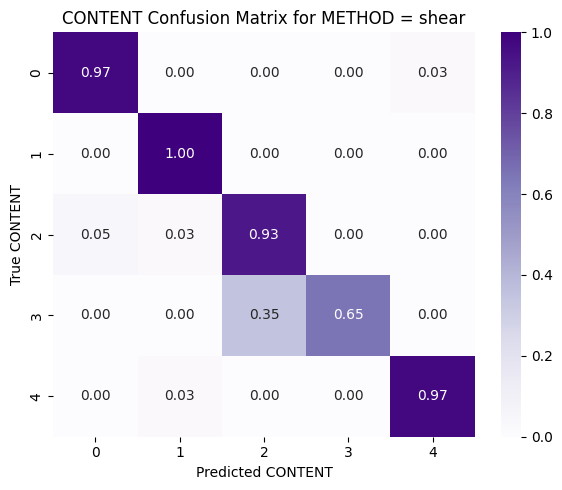

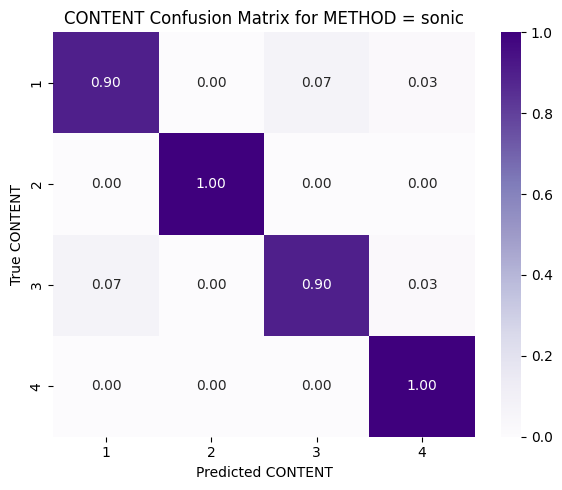

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_content_norm, annot=True, fmt=".2f", ax=axes[0], cmap='Blues',vmin=0, vmax=1)
axes[0].set_title("CONTENT - Total Normalized Confusion Matrix")
sns.heatmap(cm_method_norm, annot=True, fmt=".2f", ax=axes[1], cmap='Blues',vmin=0, vmax=1)
axes[1].set_title("METHOD - Total Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "total_confusion_matrices.svg"), format="svg")
plt.show()

method_name_map = {0: "shear", 1: "sonic"}

for method_code, data in method_specific_cm.items():
    y_true = np.array(data["true"])
    y_pred = np.array(data["pred"])

    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Purples',
                xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
    plt.title(f"CONTENT Confusion Matrix for METHOD = {method_name_map[method_code]}")
    plt.xlabel("Predicted CONTENT")
    plt.ylabel("True CONTENT")
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, f"content_confusion_{method_name_map[method_code]}.svg"), format="svg")
    plt.show()


## LGBM



In [ ]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier

# Directory
base_dir = "/content/drive/My Drive/Results/LGBM"
os.makedirs(base_dir, exist_ok=True)

param_grid_lgbm = {
    'lgbm__max_depth': [5, 7],
    'lgbm__num_leaves': [15, 30],
    'lgbm__min_child_samples': [15, 30],
}

# Initialize list
metrics = {
    'content_acc': [], 'content_f1': [],
    'method_acc': [], 'method_f1': []
}

for fold_idx, (train_imgs, test_imgs) in enumerate(outer_fold_sets):
    print(f"\n Fold {fold_idx + 1} - LGBM")

    # Data preparation
    X_train, y_content_train, y_disp_train, X_test, y_content_test, y_disp_test = prepare_rgb_fold_dataset(
        train_imgs, test_imgs, bins=64
    )

    pipe_lgbm = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbm', LGBMClassifier())
    ])

    # Content classifier
    grid_content = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=3)
    grid_content.fit(X_train, y_content_train)
    best_content = grid_content.best_estimator_
    y_pred_content = best_content.predict(X_test)

    # Method classifier
    grid_method = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=3)
    grid_method.fit(X_train, y_disp_train)
    best_method = grid_method.best_estimator_
    y_pred_method = best_method.predict(X_test)

    # Save
    joblib.dump(best_content, f"{base_dir}/fold{fold_idx+1}_content_model.joblib")
    joblib.dump(best_method, f"{base_dir}/fold{fold_idx+1}_method_model.joblib")

    # Evaluation
    acc_c = accuracy_score(y_content_test, y_pred_content)
    f1_c = f1_score(y_content_test, y_pred_content, average='macro')
    acc_m = accuracy_score(y_disp_test, y_pred_method)
    f1_m = f1_score(y_disp_test, y_pred_method, average='macro')

    metrics['content_acc'].append(acc_c)
    metrics['content_f1'].append(f1_c)
    metrics['method_acc'].append(acc_m)
    metrics['method_f1'].append(f1_m)

    print(f" Fold {fold_idx+1} CONTENT acc: {acc_c:.3f}, F1: {f1_c:.3f}")
    print(f" Fold {fold_idx+1} METHOD acc: {acc_m:.3f}, F1: {f1_m:.3f}")

    # Confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    cm_c = confusion_matrix(y_content_test, y_pred_content)
    cm_m = confusion_matrix(y_disp_test, y_pred_method)
    sns.heatmap(cm_c, annot=True, fmt='d', ax=axes[0], cmap='Greens')
    axes[0].set_title(f'Fold {fold_idx+1} - CONTENT (LGBM)')
    sns.heatmap(cm_m, annot=True, fmt='d', ax=axes[1], cmap='Greens')
    axes[1].set_title(f'Fold {fold_idx+1} - METHOD (LGBM)')
    plt.tight_layout()
    plt.savefig(f"{base_dir}/fold{fold_idx+1}_confusion_matrices.png")
    plt.close()

print("\n Overall LGBM Performance:")
print(f"CONTENT_Accuracy: {np.mean(metrics['content_acc']):.3f}, Macro F1: {np.mean(metrics['content_f1']):.3f}")
print(f"METHOD_Accuracy: {np.mean(metrics['method_acc']):.3f}, Macro F1: {np.mean(metrics['method_f1']):.3f}")



🌿 Fold 1 - LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37170
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37147
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37068
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37152
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 189
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37038
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37152
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 189
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37038
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37170
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37068
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38818
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 190
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 420, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35577
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 420, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37336
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37336
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 420, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37346
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 420, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37518
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 420, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37346
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 420, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35577
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 420, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37508
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 420, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35543
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(



🌿 Fold 2 - LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36820
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36820
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36802
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37043
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37070
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36802
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37209
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Total Bins 37360
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447917 -> initscore=-0.209092
[LightGBM] [Info] Start training from score -0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 430, number of negative: 530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35346
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447917 -> initscore=-0.209092
[LightGBM] [Info] Start training from score -0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 430, number of negative: 530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37370
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447917 -> initscore=-0.209092
[LightGBM] [Info] Start training from score -0.209092


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 430, number of negative: 530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37832
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447917 -> initscore=-0.209092
[LightGBM] [Info] Start training from score -0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 430, number of negative: 530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37370
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447917 -> initscore=-0.209092
[LightGBM] [Info] Start training from score -0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 430, number of negative: 530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35355
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447917 -> initscore=-0.209092
[LightGBM] [Info] Start training from score -0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Total Bins 35346
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447917 -> initscore=-0.209092
[LightGBM] [Info] Start training from score -0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(



🌿 Fold 3 - LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37190
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37056
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37037
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37056
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36773
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37037
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37037
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36755
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 189
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38755
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 190
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 416, number of negative: 544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35419
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268264
[LightGBM] [Info] Start training from score -0.268264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 416, number of negative: 544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35419
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268264
[LightGBM] [Info] Start training from score -0.268264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Total Bins 37084
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434375 -> initscore=-0.264023
[LightGBM] [Info] Start training from score -0.264023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 416, number of negative: 544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35394
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268264
[LightGBM] [Info] Start training from score -0.268264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 417, number of negative: 543
[LightGBM] [Info] Auto-choosing c

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 417, number of negative: 543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37805
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434375 -> initscore=-0.264023
[LightGBM] [Info] Start training from score -0.264023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 417, number of negative: 543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37795
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434375 -> initscore=-0.264023
[LightGBM] [Info] Start training from score -0.264023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38755
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434028 -> initscore=-0.265436
[LightGBM] [Info] Start training from score -0.265436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(



🌿 Fold 4 - LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36982
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37014
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37013
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 187
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36982
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 440, number of negative: 520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35328
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 440, number of negative: 520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37555
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 440, number of negative: 520


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37555
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 440, number of negative: 520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35328
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054


/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 440, number of negative: 520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37568
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 440, number of negative: 520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35328
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 440, number of negative: 520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35303
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 440, number of negative: 520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37555
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


✅ Fold 4 CONTENT acc: 0.944, F1: 0.950
✅ Fold 4 METHOD acc: 1.000, F1: 1.000

🌿 Fold 5 - LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36650
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37041
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37041
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37023
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 189
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37023
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 189
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Total Bins 36650
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.203494
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37041
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37041
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36905
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 189
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36905
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 189
[LightGBM] [Info] Start training from score -2.194104
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Info] Start training from score -1.500957
[LightGBM] [Info] Start training from score -1.505641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 426, number of negative: 534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35537
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443750 -> initscore=-0.225956
[LightGBM] [Info] Start training from score -0.225956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 427, number of negative: 533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37198
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444792 -> initscore=-0.221737
[LightGBM] [Info] Start training from score -0.221737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 426, number of negative: 534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35511
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 185
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443750 -> initscore=-0.225956
[LightGBM] [Info] Start training from score -0.225956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 427, number of negative: 533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37208
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444792 -> initscore=-0.221737
[LightGBM] [Info] Start training from score -0.221737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 427, number of negative: 533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37683
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444792 -> initscore=-0.221737
[LightGBM] [Info] Start training from score -0.221737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 427, number of negative: 533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37208
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444792 -> initscore=-0.221737
[LightGBM] [Info] Start training from score -0.221737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 426, number of negative: 534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35537
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443750 -> initscore=-0.225956
[LightGBM] [Info] Start training from score -0.225956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 427, number of negative: 533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37683
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444792 -> initscore=-0.221737
[LightGBM] [Info] Start training from score -0.221737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 426, number of negative: 534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35511
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 185
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443750 -> initscore=-0.225956
[LightGBM] [Info] Start training from score -0.225956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 426, number of negative: 534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35511
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 185
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443750 -> initscore=-0.225956
[LightGBM] [Info] Start training from score -0.225956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(



📊 Overall LGBM Performance:
CONTENT - Accuracy: 0.931, Macro F1: 0.938
METHOD  - Accuracy: 0.981, Macro F1: 0.980


In [ ]:
import joblib

base_dir = "/content/drive/My Drive/Results/LGBM"

print("Best hyperparameters:")

for fold_idx in range(5):
    # Load model
    content_model = joblib.load(f"{base_dir}/fold{fold_idx+1}_content_model.joblib")
    method_model = joblib.load(f"{base_dir}/fold{fold_idx+1}_method_model.joblib")

    # Extract hyperparameters
    content_params = content_model.named_steps['lgbm'].get_params()
    method_params = method_model.named_steps['lgbm'].get_params()

    print(f"\n Fold {fold_idx+1}")
    print(f"CONTENT Params: max_depth={content_params['max_depth']}, num_leaves={content_params['num_leaves']}, min_child_samples={content_params['min_child_samples']}")
    print(f"METHOD  Params: max_depth={method_params['max_depth']}, num_leaves={method_params['num_leaves']}, min_child_samples={method_params['min_child_samples']}")


In [ ]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier

# Directory
base_dir = "/content/drive/My Drive/Results/LGBM"
os.makedirs(base_dir, exist_ok=True)

# Initialization
cm_content_total = None
cm_method_total = None

method_specific_cm = {
    0: {"true": [], "pred": []},  # shear
    1: {"true": [], "pred": []}   # sonic
}

for fold_idx in range(5):
    # Load model
    content_model = joblib.load(f"{base_dir}/fold{fold_idx+1}_content_model.joblib")
    method_model = joblib.load(f"{base_dir}/fold{fold_idx+1}_method_model.joblib")

    # Test dataset
    train_imgs, test_imgs = outer_fold_sets[fold_idx]
    X_test, y_content_test, y_disp_test = prepare_rgb_fold_test_dataset(train_imgs, test_imgs, bins=64)

    # Prediction
    y_pred_content = content_model.predict(X_test)
    y_pred_method = method_model.predict(X_test)

    # Confusion matrix
    cm_c = confusion_matrix(y_content_test, y_pred_content)
    cm_m = confusion_matrix(y_disp_test, y_pred_method)

    cm_content_total = cm_c if cm_content_total is None else cm_content_total + cm_c
    cm_method_total = cm_m if cm_method_total is None else cm_method_total + cm_m

    for method_code in method_specific_cm.keys():
        mask = np.array(y_disp_test) == method_code
        method_specific_cm[method_code]["true"].extend(np.array(y_content_test)[mask])
        method_specific_cm[method_code]["pred"].extend(np.array(y_pred_content)[mask])

# Normalization
cm_content_norm = cm_content_total.astype('float') / cm_content_total.sum(axis=1)[:, np.newaxis]
cm_method_norm = cm_method_total.astype('float') / cm_method_total.sum(axis=1)[:, np.newaxis]


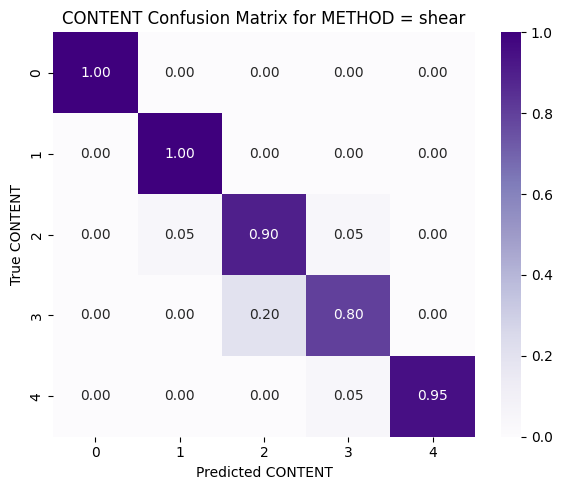

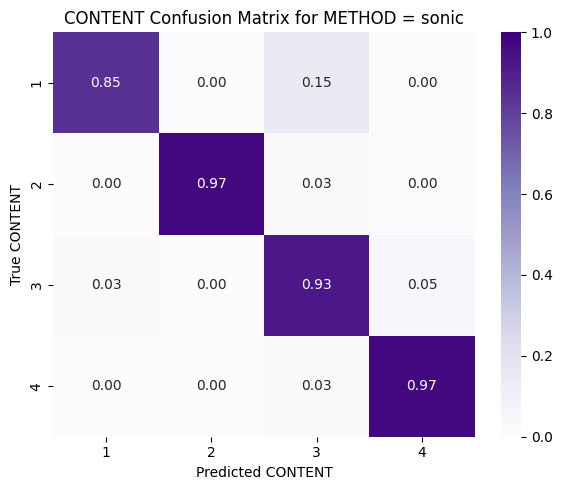

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_content_norm, annot=True, fmt=".2f", ax=axes[0], cmap='Blues', vmin=0, vmax=1)
axes[0].set_title("CONTENT - Total Normalized Confusion Matrix")
sns.heatmap(cm_method_norm, annot=True, fmt=".2f", ax=axes[1], cmap='Blues', vmin=0, vmax=1)
axes[1].set_title("METHOD - Total Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "total_confusion_matrices.svg"), format="svg")
plt.show()

method_name_map = {0: "shear", 1: "sonic"}

for method_code, data in method_specific_cm.items():
    y_true = np.array(data["true"])
    y_pred = np.array(data["pred"])

    if len(y_true) == 0:
        print(f" METHOD = {method_name_map[method_code]} 에 해당하는 샘플이 없습니다.")
        continue

    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Purples',
                xticklabels=labels, yticklabels=labels,vmin=0, vmax=1)
    plt.title(f"CONTENT Confusion Matrix for METHOD = {method_name_map[method_code]}")
    plt.xlabel("Predicted CONTENT")
    plt.ylabel("True CONTENT")
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, f"content_confusion_{method_name_map[method_code]}.svg"), format="svg")
    plt.show()